# Lab | Making predictions with logistic regression

In this lab, you will be using the [Sakila](https://dev.mysql.com/doc/sakila/en/) database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

### Instructions

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.
2. Read the data into a Pandas dataframe.
3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.
4. Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.
5. Create a logistic regression model to predict this variable from the cleaned data.
6. Evaluate the results.

# Getting the data

In [129]:
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [130]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")
from sklearn.preprocessing import StandardScaler

In [131]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

In [132]:
# Getting films, release year, rental_rate, rating, category
query1="""select f.film_id, release_year, rental_rate, length, rating, name as category from sakila.film as f
join sakila.film_category as fc
on f.film_id=fc.film_id
join sakila.category as c
on fc.category_id=c.category_id
order by film_id"""

df1 = pd.read_sql_query(query1, engine)
df1.head()

,film_id,release_year,rental_rate,length,rating,category
0,1,2006,0.99,86,PG,Documentary
1,2,2006,4.99,48,G,Horror
2,3,2006,2.99,50,NC-17,Documentary
3,4,2006,2.99,117,G,Horror
4,5,2006,2.99,130,G,Family


In [133]:
#Total times rented this month
# Getting films, release year, rental_rate, rating, category
query2="""select f.film_id, count(*) as total_times_rented from sakila.film as f
left join sakila.inventory as i
on f.film_id=i.film_id
left join sakila.rental as r
on i.inventory_id=r.inventory_id
group by f.film_id
order by f.film_id"""

df2 = pd.read_sql_query(query2, engine)
df2=df2.drop("film_id",axis=1)
df2.head()

,total_times_rented
0,24
1,7
2,12
3,23
4,12


In [134]:
query3="""select f.film_id, count(r.rental_id) as "Last month rentals" from sakila.film as f
left join sakila.inventory as i
on f.film_id=i.film_id
left outer join sakila.rental as r
on i.inventory_id=r.inventory_id and (r.rental_date >= '2005-05-15') and (r.rental_date <= '2005-05-30')
group by f.film_id
order by f.film_id"""

df3 = pd.read_sql_query(query3, engine)
df3=df3.drop("film_id",axis=1)
df3.head()

,Last month rentals
0,1
1,0
2,0
3,1
4,1


In [135]:
df3["Last month rentals"].value_counts()

0    435
1    353
2    163
3     41
4      7
5      1
Name: Last month rentals, dtype: int64

In [136]:
for i in range(len(df3)):
    if df3.loc[i, "Last month rentals"]>0:
        df3.loc[i, "Last month rentals"]='Yes'
    else:
        df3.loc[i, "Last month rentals"]='No'

In [137]:
df3.head()

,Last month rentals
0,Yes
1,No
2,No
3,Yes
4,Yes


In [138]:
df3["Last month rentals"].value_counts()

Yes    565
No     435
Name: Last month rentals, dtype: int64

In [139]:
query4="""select f.film_id, count(r.rental_id) as "This month rentals" from sakila.film as f
left join sakila.inventory as i
on f.film_id=i.film_id
left outer join sakila.rental as r
on i.inventory_id=r.inventory_id and (r.rental_date >= '2005-06-15') and (r.rental_date <= '2005-06-30')
group by f.film_id
order by f.film_id"""

df4 = pd.read_sql_query(query4, engine)
df4=df4.drop("film_id",axis=1)
df4.head()

,This month rentals
0,3
1,0
2,1
3,2
4,2


In [140]:
for i in range(len(df4)):
    if df4.loc[i, "This month rentals"]>0:
        df4.loc[i, "This month rentals"]='Yes'
    else:
        df4.loc[i, "This month rentals"]='No'

In [141]:
df4.head()

,This month rentals
0,Yes
1,No
2,Yes
3,Yes
4,Yes


In [142]:
query5="""
select f.film_id, count(*) inventory_copies from sakila.film as f
left join sakila.inventory as i
on f.film_id=i.film_id
group by f.film_id
order by f.film_id"""

df5 = pd.read_sql_query(query5, engine)
df5=df5.drop("film_id",axis=1)
df5.head()

,inventory_copies
0,8
1,3
2,4
3,7
4,3


In [143]:
df=pd.concat([df1,df2,df5,df3,df4], axis=1)

In [144]:
df

,film_id,release_year,rental_rate,length,rating,category,total_times_rented,inventory_copies,Last month rentals,This month rentals
0,1,2006,0.99,86,PG,Documentary,24,8,Yes,Yes
1,2,2006,4.99,48,G,Horror,7,3,No,No
2,3,2006,2.99,50,NC-17,Documentary,12,4,No,Yes
3,4,2006,2.99,117,G,Horror,23,7,Yes,Yes
4,5,2006,2.99,130,G,Family,12,3,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...
995,996,2006,0.99,183,G,Documentary,7,2,No,Yes
996,997,2006,0.99,179,NC-17,Music,6,2,No,Yes
997,998,2006,0.99,105,NC-17,Horror,9,2,No,Yes
998,999,2006,2.99,101,R,Children,17,5,No,Yes


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   film_id             1000 non-null   int64  
 1   release_year        1000 non-null   int64  
 2   rental_rate         1000 non-null   float64
 3   length              1000 non-null   int64  
 4   rating              1000 non-null   object 
 5   category            1000 non-null   object 
 6   total_times_rented  1000 non-null   int64  
 7   inventory_copies    1000 non-null   int64  
 8   Last month rentals  1000 non-null   object 
 9   This month rentals  1000 non-null   object 
dtypes: float64(1), int64(5), object(4)
memory usage: 78.2+ KB


# Data Cleaning

In [146]:
df.columns

Index(['film_id', 'release_year', 'rental_rate', 'length', 'rating',
       'category', 'total_times_rented', 'inventory_copies',
       'Last month rentals', 'This month rentals'],
      dtype='object')

In [147]:
df.columns=['Film ID', 'Release Year', 'Rental Rate', 'Length', 'Rating',
       'Category', 'Total Times Rented', 'Copies available',
       'Last Month Rentals', 'This Month Rentals']

In [148]:
df.head()

,Film ID,Release Year,Rental Rate,Length,Rating,Category,Total Times Rented,Copies available,Last Month Rentals,This Month Rentals
0,1,2006,0.99,86,PG,Documentary,24,8,Yes,Yes
1,2,2006,4.99,48,G,Horror,7,3,No,No
2,3,2006,2.99,50,NC-17,Documentary,12,4,No,Yes
3,4,2006,2.99,117,G,Horror,23,7,Yes,Yes
4,5,2006,2.99,130,G,Family,12,3,Yes,Yes


In [149]:
df["Release Year"]=pd.to_datetime(df["Release Year"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Film ID             1000 non-null   int64         
 1   Release Year        1000 non-null   datetime64[ns]
 2   Rental Rate         1000 non-null   float64       
 3   Length              1000 non-null   int64         
 4   Rating              1000 non-null   object        
 5   Category            1000 non-null   object        
 6   Total Times Rented  1000 non-null   int64         
 7   Copies available    1000 non-null   int64         
 8   Last Month Rentals  1000 non-null   object        
 9   This Month Rentals  1000 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 78.2+ KB


In [150]:
df.drop_duplicates()

,Film ID,Release Year,Rental Rate,Length,Rating,Category,Total Times Rented,Copies available,Last Month Rentals,This Month Rentals
0,1,1970-01-01 00:00:00.000002006,0.99,86,PG,Documentary,24,8,Yes,Yes
1,2,1970-01-01 00:00:00.000002006,4.99,48,G,Horror,7,3,No,No
2,3,1970-01-01 00:00:00.000002006,2.99,50,NC-17,Documentary,12,4,No,Yes
3,4,1970-01-01 00:00:00.000002006,2.99,117,G,Horror,23,7,Yes,Yes
4,5,1970-01-01 00:00:00.000002006,2.99,130,G,Family,12,3,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...
995,996,1970-01-01 00:00:00.000002006,0.99,183,G,Documentary,7,2,No,Yes
996,997,1970-01-01 00:00:00.000002006,0.99,179,NC-17,Music,6,2,No,Yes
997,998,1970-01-01 00:00:00.000002006,0.99,105,NC-17,Horror,9,2,No,Yes
998,999,1970-01-01 00:00:00.000002006,2.99,101,R,Children,17,5,No,Yes


In [151]:
#Drop Film Id as in our case it will not be relevant
df=df.drop("Film ID", axis=1)

# Data Processing 

### I. x-y split

In [152]:
y=df["This Month Rentals"]
x=df.drop(["This Month Rentals"], axis=1)

### II. Numerical data

In [153]:
#Getting the numerical data 
x_num=df.select_dtypes("number")
x_num.head()

,Rental Rate,Length,Total Times Rented,Copies available
0,0.99,86,24,8
1,4.99,48,7,3
2,2.99,50,12,4
3,2.99,117,23,7
4,2.99,130,12,3


In [154]:
x_num.describe()

,Rental Rate,Length,Total Times Rented,Copies available
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.980000,115.272000,16.087000,4.623000
std,1.646393,40.426332,7.259486,1.933031
min,0.990000,46.000000,1.000000,1.000000
25%,0.990000,80.000000,11.000000,3.000000
50%,2.990000,114.000000,16.000000,5.000000
75%,4.990000,149.250000,21.000000,6.000000
max,4.990000,185.000000,34.000000,8.000000


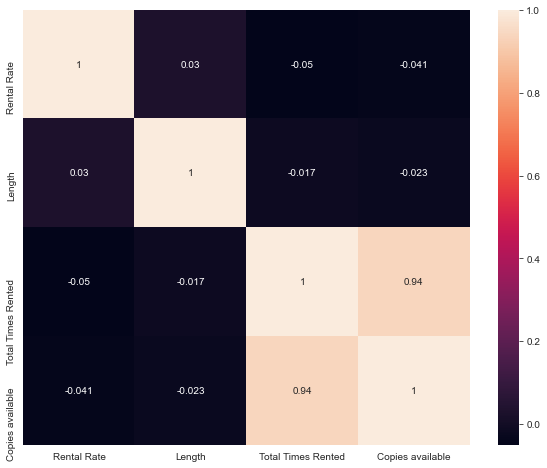

In [155]:
#Multicolinearity check
corr_matrix=df.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [156]:
x_num.corr()

,Rental Rate,Length,Total Times Rented,Copies available
Rental Rate,1.000000,0.029789,-0.050178,-0.041446
Length,0.029789,1.000000,-0.017282,-0.022794
Total Times Rented,-0.050178,-0.017282,1.000000,0.940510
Copies available,-0.041446,-0.022794,0.940510,1.000000


Distplot:  Rental Rate


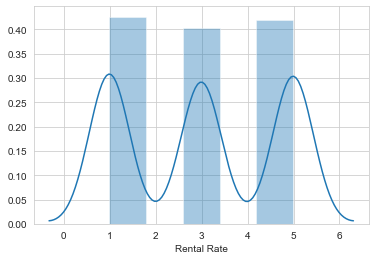

Distplot:  Length


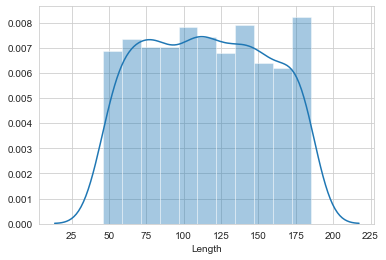

Distplot:  Total Times Rented


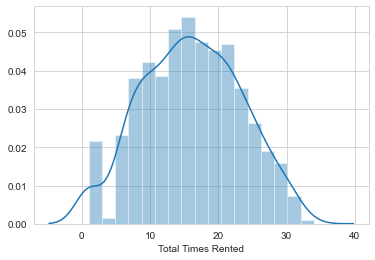

Distplot:  Copies available


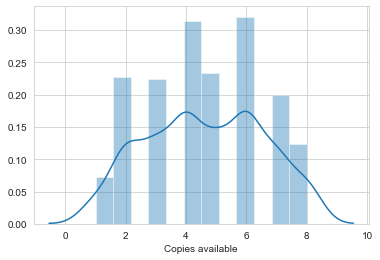

In [157]:
#Normalisation check
cols = list(x_num)
for col in cols:
    print("Distplot: ",col)
    sns.distplot(x_num[col])
    plt.show()

In [158]:
#Normalisation
from sklearn.preprocessing import Normalizer

scaler=Normalizer().fit(x_num)
x_normalised=scaler.transform(x_num)
x_num_norm=pd.DataFrame(x_normalised)
x_num_norm.head()

,0,1,2,3
0,0.011043,0.959295,0.267710,0.089237
1,0.102137,0.982481,0.143278,0.061405
2,0.057876,0.967833,0.232280,0.077427
3,0.025025,0.979227,0.192498,0.058586
4,0.022891,0.995243,0.091869,0.022967


In [159]:
x_num_norm.columns=x_num.columns
x_num_norm.head()

,Rental Rate,Length,Total Times Rented,Copies available
0,0.011043,0.959295,0.267710,0.089237
1,0.102137,0.982481,0.143278,0.061405
2,0.057876,0.967833,0.232280,0.077427
3,0.025025,0.979227,0.192498,0.058586
4,0.022891,0.995243,0.091869,0.022967


Distplot:  Rental Rate


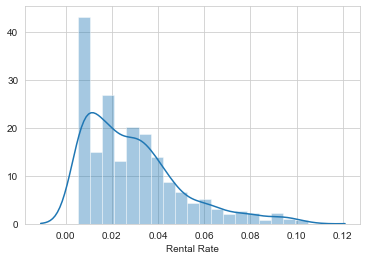

Distplot:  Length


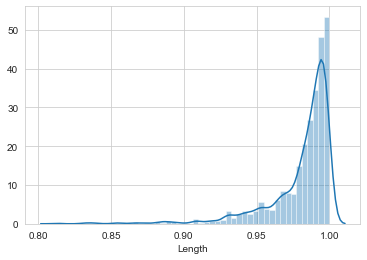

Distplot:  Total Times Rented


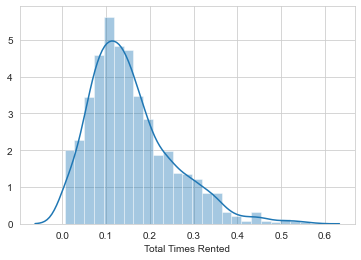

Distplot:  Copies available


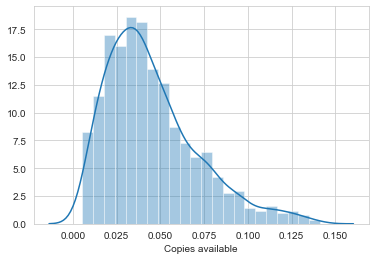

In [160]:
#Plot after normalisation
cols = list(x_num_norm)
for col in cols:
    print("Distplot: ",col)
    sns.distplot(x_num_norm[col])
    plt.show()

We can see the distribution has improved

### III. Categorical Data

In [161]:
#Getting the categorical data
x_cat=x.select_dtypes("object")
x_cat.head()

,Rating,Category,Last Month Rentals
0,PG,Documentary,Yes
1,G,Horror,No
2,NC-17,Documentary,No
3,G,Horror,Yes
4,G,Family,Yes


In [162]:
#Dummies
x_cat_dummies=pd.get_dummies(x_cat, drop_first=False, dtype=None)
x_cat_dummies.head()

,Rating_G,Rating_NC-17,Rating_PG,Rating_PG-13,Rating_R,Category_Action,Category_Animation,Category_Children,Category_Classics,Category_Comedy,...,Category_Foreign,Category_Games,Category_Horror,Category_Music,Category_New,Category_Sci-Fi,Category_Sports,Category_Travel,Last Month Rentals_No,Last Month Rentals_Yes
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [163]:
### IV. Concatenate x data
x_processed=pd.concat([x_cat_dummies,x_num_norm],axis=1)
x_processed.head()

,Rating_G,Rating_NC-17,Rating_PG,Rating_PG-13,Rating_R,Category_Action,Category_Animation,Category_Children,Category_Classics,Category_Comedy,...,Category_New,Category_Sci-Fi,Category_Sports,Category_Travel,Last Month Rentals_No,Last Month Rentals_Yes,Rental Rate,Length,Total Times Rented,Copies available
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.011043,0.959295,0.267710,0.089237
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0.102137,0.982481,0.143278,0.061405
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0.057876,0.967833,0.232280,0.077427
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.025025,0.979227,0.192498,0.058586
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.022891,0.995243,0.091869,0.022967


# V. The Model

In [164]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_processed, y, test_size=0.2, random_state=250)

In [165]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr').fit(x_train, y_train)

In [166]:
from sklearn.metrics import accuracy_score
predictions = classification.predict(x_test)

The accuracy of the model on test set is: 0.90 


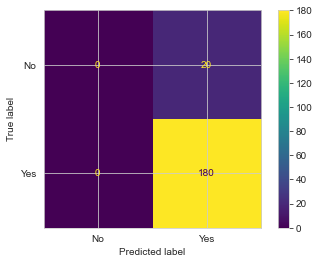

Cohen Kappa score 0.0


In [167]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
confusion_matrix(y_test, predictions)
plot_confusion_matrix(classification, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

from sklearn.metrics import cohen_kappa_score
print('Cohen Kappa score',cohen_kappa_score(y_test, predictions))

In [168]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test, labels=['Yes','No']))

              precision    recall  f1-score   support

         Yes       1.00      1.00      1.00       180
          No       1.00      1.00      1.00        20

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



### Synthetic Minority Oversampling TEchnique (SMOTE)

In [171]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

transformer = StandardScaler().fit(x_processed)
X = transformer.transform(x_processed)
X_sm, y_sm = smote.fit_sample(X, y)
y_sm = pd.DataFrame(data=y_sm)

In [181]:
y_sm["This Month Rentals"].value_counts()

Yes    900
No     900
Name: This Month Rentals, dtype: int64

In [186]:
import warnings
warnings.filterwarnings('ignore')

In [190]:
#Testing the model
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=250)

In [191]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr').fit(x_train, y_train)

In [193]:
from sklearn.metrics import accuracy_score
predictions = classification.predict(x_test)

The accuracy of the model on test set is: 0.94 


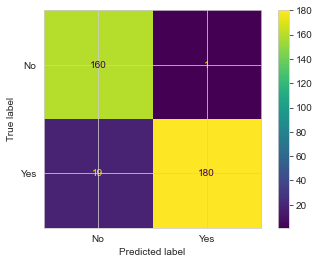

Cohen Kappa score 0.888823692906334


In [195]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
confusion_matrix(y_test, predictions)
plot_confusion_matrix(classification, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

from sklearn.metrics import cohen_kappa_score
print('Cohen Kappa score',cohen_kappa_score(y_test, predictions))

In [196]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test, labels=['Yes','No']))

              precision    recall  f1-score   support

         Yes       1.00      1.00      1.00       199
          No       1.00      1.00      1.00       161

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360



### UnderSampling using TomekLinks

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

In [197]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks('majority')
X_tl, y_tl = tl.fit_sample(X, y)
y_tl = pd.DataFrame(data=y_tl)
y_tl["This Month Rentals"].value_counts()

Yes    858
No     100
Name: This Month Rentals, dtype: int64

In [200]:
X_tl2, y_tl2 = tl.fit_sample(X_tl, y_tl)
y_tl2 = pd.DataFrame(data=y_tl2)
y_tl2["This Month Rentals"].value_counts()

Yes    845
No     100
Name: This Month Rentals, dtype: int64

In [204]:
#Testing the model
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_tl2, y_tl2, test_size=0.2, random_state=250)

In [205]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr').fit(x_train, y_train)

In [206]:
from sklearn.metrics import accuracy_score
predictions = classification.predict(x_test)

The accuracy of the model on test set is: 0.97 


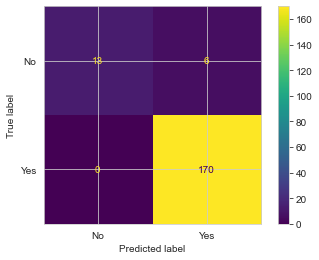

Cohen Kappa score 0.7958228303925099


In [207]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
confusion_matrix(y_test, predictions)
plot_confusion_matrix(classification, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

from sklearn.metrics import cohen_kappa_score
print('Cohen Kappa score',cohen_kappa_score(y_test, predictions))

In [208]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test, labels=['Yes','No']))

              precision    recall  f1-score   support

         Yes       1.00      1.00      1.00       170
          No       1.00      1.00      1.00        19

    accuracy                           1.00       189
   macro avg       1.00      1.00      1.00       189
weighted avg       1.00      1.00      1.00       189

